# Notice 

해당 코드는 아래의 GitHub에서도 확인할 수 있습니다.  
[https://github.com/LGAimers/AI-PTA]

GAN, CGAN 기반 방법론 코드는 아래의 Colab Notebook을 통해 확인할 수 있습니다.  
[https://drive.google.com/drive/u/3/folders/1TrXWS8KCM-93ToTWDHf167OUyS72dOCp]

# 0. Libraries 

!pip install pycaret

PyCaret is tested and supported on 64-bit systems with:
- Python 3.8, 3.9, 3.10, and 3.11
- Ubuntu 16.04 or later
- Windows 7 or later

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white')

from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, precision_score, recall_score

import tensorflow as tf

import warnings
warnings.filterwarnings(action='ignore')

# SEED 번호 고정
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [43]:
# GPU를 사용할 수 있는 환경이면 True, 아니면 False
import os
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
print(tf.config.list_physical_devices('GPU'))

os.environ["CUDA_VISIBLE_DEVICES"] = '0'                   # 여러개 사용시 '0,1,2' 식으로 하나의 문자열에 입력
gpus = tf.config.experimental.list_physical_devices('GPU') # 호스트 런타임에 표시되는 GPU 장치 목록 반환

GPU = True
if gpus: # 반환된 GPU 장치 목록이 있다면
    try: # 해당 장치에 대한 메모리 증가 활성화 여부 설정
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e: # try문 실패시에 에러문구 출력
        GPU = False
        print(e)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14520692002591133786
xla_global_id: -1
]
[]


# 1. Dataset

Original Dataset 
-> T&O data와 A data로 분할 
-> A data에 대해 T503 LINE과 T103 LINE 데이터 2가지로 분할 

dataset(3) = [T&O data, A-T503, A-T103]

- 그러나, 동일한 실험 조건을 수행하기 위해 T&O data만 활용하였음 -> EXPERIMENT = 0
- 모든 데이터에 대해 코드를 돌려보고 싶을 경우 -> EXPERIMENT = 2

In [32]:
# 실험하고자 하는 data 군집 번호 (Configuration)
EXPERIMENT = 0

In [33]:
path = "./Dataset/"

# original data -> original
original = pd.read_csv(path+"train.csv")  
original = original.drop(['PRODUCT_ID'], axis=1)        # PRODUCT_ID: 제품 고유의 ID

# Original data -> T&O and A data 
dataT = original[original['PRODUCT_CODE'] =='T_31']
dataO = original[original['PRODUCT_CODE'] =='O_31']
dataA = original[original['PRODUCT_CODE'] =='A_31']
dataTO = pd.concat([dataT, dataO])

# A data -> A-T503 and A-T103 data
t50304 = dataA[dataA['LINE'] =='T050304']
t50307 = dataA[dataA['LINE'] =='T050307']
t10305 = dataA[dataA['LINE'] =='T010305']
t10306 = dataA[dataA['LINE'] =='T010306']
dataA503 = pd.concat([t50304, t50307]).reset_index(drop=True)
dataA103 = pd.concat([t10305, t10306]).reset_index(drop=True)

print("Original data: ", original.shape)
print("T data: ", dataT.shape)
print("O data: ", dataO.shape)
print("A data: ", dataA.shape)
print("A - T503 data: ", dataA503.shape)
print("A - T103 data: ", dataA103.shape)

original

Original data:  (1132, 3330)
T data:  (830, 3330)
O data:  (8, 3330)
A data:  (294, 3330)
A - T503 data:  (152, 3330)
A - T103 data:  (142, 3330)


,Y_Class,Y_Quality,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_3317,X_3318,X_3319,X_3320,X_3321,X_3322,X_3323,X_3324,X_3325,X_3326
0,1,0.531957,T100304,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,0.000008,0.000003,0.191408,0.000008,0.001210,0.000021,0.000003,0.000002,0.189,0.000006
1,1,0.531105,T100306,T_31,2.0,96.0,0.0,45.0,10.0,0.0,...,0.000008,0.000003,0.188993,0.000032,0.000644,0.000041,0.000002,0.000003,0.185,0.000029
2,1,0.532292,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,0.528141,T100306,T_31,2.0,87.0,0.0,45.0,10.0,0.0,...,0.000007,0.000003,0.189424,0.000034,0.000678,0.000043,0.000004,0.000003,0.188,0.000031
4,1,0.532289,T100306,T_31,2.0,95.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,0,0.516681,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1128,1,0.530413,T100304,T_31,2.0,102.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1129,1,0.533311,T100306,T_31,1.0,88.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1130,0,0.513135,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
dataset = [dataTO, dataA503, dataA103]

for i, data in enumerate(dataset):
    print(str(i), "-> shape: ", data.shape)

0 -> shape:  (838, 3330)
1 -> shape:  (152, 3330)
2 -> shape:  (142, 3330)


# 2. Preprocessing

기본 전처리 과정은 아래의 5가지 단계를 거치며,  
TO data에 대해서는 lightgbm기반 feature selection을(Pycaret), A data에 대해서는 다중공선성을 제거(threshold=0.9)를 추가적으로 진행한다. 

1. 결측치 처리 (fillna(0))
2. 같은 값으로만 채워진 column 삭제
3. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제 
4. 정규화 (Robust Scaler)
5. 카테고리 변수 (LINE, PRODUCT_CODE) 수치화 (LabelEncoder)

In [35]:
# Default Preprocessing Step
processed_dataset = []

rs = RobustScaler()
le = LabelEncoder() 
le.fit(original['LINE'])
print(le.classes_, '\n')

for data in dataset:
    # 1. Handling missing values 
    data = data.copy().fillna(0)
    print("0) 원본 데이터 -> ", data.shape)

    # 2. 같은 값으로만 채워진 column 삭제 
    value_counts = data.iloc[:,4:].apply(lambda x: x.nunique(dropna=False))
    unique_columns = value_counts[value_counts >= 2].index
    duplicated_columns = value_counts[value_counts <= 1].index
    data = data.drop(duplicated_columns, axis=1)
    print("1) 같은 값으로만 채워진 변수 제거 -> ", data.shape)

    # 3. 모든 행이 같은 값을 가지는 두 개 이상의 중복된 column 삭제
    df = data.iloc[:,4:].T.drop_duplicates(keep='first').T
    data = pd.concat([data.iloc[:,:4], df], axis=1)
    print("2) 모든 행이 같은 값을 가지는 중복된 변수 제거 -> ", data.shape)

    # 4. Regularization -> Robust Scaler 
    data.iloc[:, 4:] = rs.fit_transform(data.iloc[:, 4:])

    # 5. Label Encoding 
    data['LINE'] = le.transform(data['LINE'])
    data['PRODUCT_CODE'] = data['PRODUCT_CODE'].replace({'T_31': 0, 'O_31':1, 'A_31': 2})    

    processed_dataset.append(data)
    print()

['T010305' 'T010306' 'T050304' 'T050307' 'T100304' 'T100306'] 

0) 원본 데이터 ->  (838, 3330)
1) 같은 값으로만 채워진 변수 제거 ->  (838, 1030)
2) 모든 행이 같은 값을 가지는 중복된 변수 제거 ->  (838, 682)

0) 원본 데이터 ->  (152, 3330)
1) 같은 값으로만 채워진 변수 제거 ->  (152, 1811)
2) 모든 행이 같은 값을 가지는 중복된 변수 제거 ->  (152, 1094)

0) 원본 데이터 ->  (142, 3330)
1) 같은 값으로만 채워진 변수 제거 ->  (142, 754)
2) 모든 행이 같은 값을 가지는 중복된 변수 제거 ->  (142, 597)



In [36]:
# Optional Preprocessing Step - 6. Multicollinearity for A data 
from collinearity import SelectNonCollinear

OPTION = [1, 2] # 다중공선성제거를 진행할 데이터 군집 번호 설정 (Configuration)

for i, data in enumerate(processed_dataset):
    if i not in OPTION: continue

    print("0) 원본 데이터 -> ", data.shape)
    nonX_data = data.iloc[:, :4]
    X_data = data.iloc[:, 4:]
    
    selector = SelectNonCollinear(0.9)
    selector.fit(X_data.values)
    mask = selector.get_support() # True or False
    
    selected_df = pd.DataFrame(X_data.loc[:,mask])
    data = pd.concat([nonX_data, selected_df], axis=1)
    processed_dataset[i] =  data
    print("1) 다중공선성제거 후 데이터 -> ", data.shape, '\n')

0) 원본 데이터 ->  (152, 1094)
1) 다중공선성제거 후 데이터 ->  (152, 417) 

0) 원본 데이터 ->  (142, 597)
1) 다중공선성제거 후 데이터 ->  (142, 398) 



In [37]:
# 최종 전처리 진행 후 데이터 차원 수 확인
for i, data in enumerate(processed_dataset):
    print(str(i), "-> shape: ", data.shape)

0 -> shape:  (838, 682)
1 -> shape:  (152, 417)
2 -> shape:  (142, 398)


# 3. Data Split

Y_Quality를 맞추기 위해 X변수들을 학습하는 Regressor모델은 아래와 같은 Train dataset을 가져갑니다.  
Test Dataset은 동일한 실험 조건을 갖추기 위해 T&O data (200)만 사용하였습니다.  
마찬가지로 Train Dataset 또한 T&O data (638)을 이용하지만, A 데이터에 대한 실험 또한 진행할 수 있습니다.  
Anomaly Detection 모델은 T&O data에 대한 Normal data만 사용하므로 추후 나올 코드에서 데이터를 다시 분할하여 사용합니다.  (Test Dataset은 동일)


**T&O data** 
- Train Data (638, 682)
- Test Data (200, 682)
    - Abnoraml (100)
    - Normal (100)

**A-T503 data**
- Train Data (76, 417)
- Test Data (76, 417)
    - Abnormal (51)
    - Normal (25)

**A-T503 data**
- Train Data (76, 417)
- Test Data (76, 417)
    - Abnormal (51)
    - Normal (25)

In [40]:
input_dataset = processed_dataset.copy()

test_dataset = []
train_dataset = []
normal_dataset = []
abnormal_dataset = []

for i, data in enumerate(input_dataset): 
    print(str(i), '-> Data:', data.shape)
    
    # Divide processed_data to abnormal and normal 
    normal_data = data[data['Y_Class']==1]
    normal_data['Y_Class'] = normal_data['Y_Class'].replace({1: 0}) # normal -> 0
    
    undershoot = data[data['Y_Class']==0]
    overshoot = data[data['Y_Class']==2]
    abnormal_data = pd.concat([undershoot, overshoot])
    abnormal_data['Y_Class'] = abnormal_data['Y_Class'].replace({2: 1, 0: 1}) # abnormal -> 1 

    normal_dataset.append(normal_data)
    abnormal_dataset.append(abnormal_data)
    print(str(i), '-> Normal Data:', normal_data.shape, ', Abnormal Data:', abnormal_data.shape)

    # Create test data (normal 65, abnormal 82 = 147)
    if i==0: LENGTH0, LENGTH1 = 100, 100        
    elif i==1: LENGTH0, LENGTH1 = len(normal_data)//2 + 1, len(abnormal_data)//2
    elif i==2: LENGTH0, LENGTH1 = len(normal_data)//2, len(abnormal_data)//2 + 1
    test_normal = normal_data.sample(n = LENGTH0, random_state = SEED)
    test_abnormal = abnormal_data.sample(n = LENGTH1, random_state = SEED) 
    test_data = pd.concat([test_normal, test_abnormal])
    
    test_dataset.append(test_data)
    print(str(i), '-> Test Data:', test_data.shape)

    # Create train data based on normal data (638)
    train_normal = normal_data.drop(test_normal.index)
    train_abnormal = abnormal_data.drop(test_abnormal.index)
    train_data = pd.concat([train_normal, train_abnormal])
    
    train_dataset.append(train_data)
    print(str(i), '-> Train Data:', train_data.shape, '\n')

0 -> Data: (838, 682)
0 -> Normal Data: (636, 682) , Abnormal Data: (202, 682)
0 -> Test Data: (200, 682)
0 -> Train Data: (638, 682) 

1 -> Data: (152, 417)
1 -> Normal Data: (51, 417) , Abnormal Data: (101, 417)
1 -> Test Data: (76, 417)
1 -> Train Data: (76, 417) 

2 -> Data: (142, 398)
2 -> Normal Data: (79, 398) , Abnormal Data: (63, 398)
2 -> Test Data: (71, 398)
2 -> Train Data: (71, 398) 



# 4. Regression for Y_Quality 

X변수들을 기반으로 Pycaret을 통해 Regressor 모델을 학습시켜 Y_Quality를 예측합니다.  
T&O data에 대해 일반적으로 Extra Trees Regressor, CatBoost Regressor, Extreme Gradient Regressor가 가장 좋은 성능을 보였습니다.  


## 4.1. Training

Pycaret이라는 AutoML Library를 통해 학습합니다. 

In [ ]:
best_models = [] 

In [44]:
from pycaret.regression import *
from time import time

# Setup Environment  
cat_cols = ['LINE', 'PRODUCT_CODE', 'Y_Class']
FOLD = 5
NUMBER = EXPERIMENT  # 0: dataTO, 1: A-T503, 2: AT103

reg = setup(data = train_dataset[NUMBER], 
            train_size = 0.8,
            test_data = test_dataset[NUMBER],
            target = 'Y_Quality',
            ignore_features = cat_cols,
            feature_selection = True,
            n_features_to_select = 0.2, # default 0.2
            fold=FOLD,                  # defualt 10 
            fold_shuffle=True,
            use_gpu = GPU,
            session_id = SEED)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

,Description,Value
0,Session id,42
1,Target,Y_Quality
2,Target type,Regression
3,Original data shape,"(838, 682)"
4,Transformed data shape,"(838, 136)"
5,Transformed train set shape,"(638, 136)"
6,Transformed test set shape,"(200, 136)"
7,Ignore features,3
8,Numeric features,678
9,Preprocess,True


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

In [46]:
# r2 score를 기준으로 사전 학습이 가장 잘되는 5가지 모델을 추출합니다
top5 = compare_models(sort='r2', n_select=5, fold=FOLD, exclude=['lar', 'par', 'huber'])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0026,0.0000,0.0034,0.4916,0.0022,0.0049,0.4980
catboost,CatBoost Regressor,0.0027,0.0000,0.0036,0.4383,0.0023,0.0051,11.8920
xgboost,Extreme Gradient Boosting,0.0027,0.0000,0.0036,0.4147,0.0024,0.0052,0.5740
gbr,Gradient Boosting Regressor,0.0027,0.0000,0.0037,0.4034,0.0024,0.0052,1.1600
lightgbm,Light Gradient Boosting Machine,0.0028,0.0000,0.0038,0.3607,0.0025,0.0053,0.8380
ada,AdaBoost Regressor,0.0029,0.0000,0.0038,0.3592,0.0025,0.0054,0.5080
rf,Random Forest Regressor,0.0028,0.0000,0.0039,0.3415,0.0025,0.0053,0.9540
knn,K Neighbors Regressor,0.0031,0.0000,0.0044,0.1437,0.0029,0.0059,0.2840
br,Bayesian Ridge,0.0031,0.0000,0.0044,0.1314,0.0029,0.0059,0.2900
ridge,Ridge Regression,0.0032,0.0000,0.0044,0.1211,0.0029,0.0060,0.2740


In [47]:
# 사전학습 성능이 좋았던 5가지 모델을 가지고 제대로 된 학습 과정을 거친 후 hyper parameter tuning 과정을 거칩니다
# tuning을 거치기 전 모델과 거친 후 모델은 따로 저장합니다 
# tuning에 대해서, 큰 효과가 없기 때문에 시간이 오래 걸린다면 주석으로 처리하고 진행하여도 무관합니다
total_models = []
tuned_models = []

for i, model in enumerate(top5):
    cell_start_time = time() 
    print(top5[i])
    model = create_model(model, fold=FOLD)
    tuned_model = tune_model(model, fold=5, optimize='r2', choose_better=True)
    total_models.append(model)
    tuned_models.append(tuned_model)
    cell_end_time = time()
    print("CELL RUN TIME: ", cell_end_time - cell_start_time)

ExtraTreesRegressor(n_jobs=-1, random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0028,0.0000,0.0037,0.5957,0.0024,0.0052
1,0.0026,0.0000,0.0033,0.5210,0.0022,0.0049
2,0.0025,0.0000,0.0033,0.6217,0.0022,0.0048
3,0.0027,0.0000,0.0036,0.3211,0.0023,0.0051
4,0.0024,0.0000,0.0030,0.3987,0.0020,0.0045
Mean,0.0026,0.0000,0.0034,0.4916,0.0022,0.0049
Std,0.0001,0.0000,0.0002,0.1152,0.0001,0.0003


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0034,0.0000,0.0051,0.2138,0.0033,0.0064
1,0.0030,0.0000,0.0046,0.1100,0.0030,0.0056
2,0.0031,0.0000,0.0049,0.1758,0.0032,0.0058
3,0.0029,0.0000,0.0040,0.1379,0.0026,0.0054
4,0.0026,0.0000,0.0037,0.1216,0.0024,0.0048
Mean,0.0030,0.0000,0.0045,0.1518,0.0029,0.0056
Std,0.0003,0.0000,0.0005,0.0381,0.0003,0.0005


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
CELL RUN TIME:  34.36743497848511


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0029,0.0000,0.0037,0.5914,0.0024,0.0054
1,0.0028,0.0000,0.0036,0.4361,0.0024,0.0052
2,0.0027,0.0000,0.0039,0.4864,0.0025,0.0051
3,0.0027,0.0000,0.0036,0.2973,0.0024,0.0051
4,0.0024,0.0000,0.0031,0.3803,0.0020,0.0046
Mean,0.0027,0.0000,0.0036,0.4383,0.0023,0.0051
Std,0.0001,0.0000,0.0003,0.0990,0.0002,0.0003


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0029,0.0000,0.0037,0.5814,0.0024,0.0054
1,0.0029,0.0000,0.0038,0.3763,0.0025,0.0056
2,0.0028,0.0000,0.0040,0.4551,0.0026,0.0054
3,0.0027,0.0000,0.0036,0.3103,0.0024,0.0050
4,0.0025,0.0000,0.0032,0.3367,0.0021,0.0047
Mean,0.0028,0.0000,0.0037,0.4120,0.0024,0.0052
Std,0.0002,0.0000,0.0003,0.0978,0.0002,0.0003


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19061
[LightGBM] [Info] Number of data points in the train set: 510, number of used features: 661
[LightGBM] [Info] Start training from score 0.530478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0028,0.0000,0.0035,0.6361,0.0023,0.0052
1,0.0027,0.0000,0.0038,0.3755,0.0025,0.0052
2,0.0029,0.0000,0.0040,0.4600,0.0026,0.0054
3,0.0028,0.0000,0.0037,0.2827,0.0024,0.0053
4,0.0025,0.0000,0.0032,0.3193,0.0021,0.0047
Mean,0.0027,0.0000,0.0036,0.4147,0.0024,0.0052
Std,0.0001,0.0000,0.0003,0.1258,0.0002,0.0002


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0031,0.0000,0.0043,0.4542,0.0028,0.0059
1,0.0028,0.0000,0.0040,0.3258,0.0026,0.0053
2,0.0030,0.0000,0.0043,0.3782,0.0028,0.0056
3,0.0028,0.0000,0.0039,0.2053,0.0025,0.0053
4,0.0025,0.0000,0.0032,0.3112,0.0021,0.0047
Mean,0.0028,0.0000,0.0039,0.3349,0.0026,0.0053
Std,0.0002,0.0000,0.0004,0.0819,0.0002,0.0004


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19061
[LightGBM] [Info] Number of data points in the train set: 510, number of used features: 661
[LightGBM] [Info] Start training from score 0.530478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0028,0.0000,0.0035,0.6351,0.0023,0.0052
1,0.0028,0.0000,0.0037,0.4110,0.0024,0.0053
2,0.0028,0.0000,0.0041,0.4322,0.0027,0.0054
3,0.0028,0.0000,0.0038,0.2240,0.0025,0.0053
4,0.0024,0.0000,0.0032,0.3147,0.0021,0.0046
Mean,0.0027,0.0000,0.0037,0.4034,0.0024,0.0052
Std,0.0002,0.0000,0.0003,0.1376,0.0002,0.0003


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0034,0.0000,0.0050,0.2348,0.0033,0.0064
1,0.0029,0.0000,0.0044,0.1875,0.0028,0.0055
2,0.0031,0.0000,0.0047,0.2547,0.0030,0.0058
3,0.0030,0.0000,0.0040,0.1481,0.0026,0.0056
4,0.0025,0.0000,0.0033,0.2817,0.0022,0.0047
Mean,0.0030,0.0000,0.0043,0.2213,0.0028,0.0056
Std,0.0003,0.0000,0.0006,0.0478,0.0004,0.0006


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
CELL RUN TIME:  35.140862226486206
LGBMRegressor(device='gpu', n_jobs=-1, random_state=42)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0030,0.0000,0.0040,0.5082,0.0026,0.0056
1,0.0029,0.0000,0.0040,0.3229,0.0026,0.0055
2,0.0029,0.0000,0.0040,0.4444,0.0026,0.0054
3,0.0030,0.0000,0.0040,0.1558,0.0026,0.0057
4,0.0024,0.0000,0.0031,0.3705,0.0020,0.0045
Mean,0.0028,0.0000,0.0038,0.3604,0.0025,0.0053
Std,0.0002,0.0000,0.0004,0.1202,0.0002,0.0004


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0037,0.0000,0.0058,-0.0070,0.0038,0.0070
1,0.0031,0.0000,0.0048,-0.0011,0.0032,0.0059
2,0.0034,0.0000,0.0054,-0.0003,0.0035,0.0064
3,0.0032,0.0000,0.0044,-0.0007,0.0028,0.0060
4,0.0028,0.0000,0.0040,-0.0262,0.0026,0.0052
Mean,0.0032,0.0000,0.0049,-0.0071,0.0032,0.0061
Std,0.0003,0.0000,0.0007,0.0099,0.0004,0.0006


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19061
[LightGBM] [Info] Number of data points in the train set: 510, number of used features: 661
[LightGBM] [Info] Start training from score 0.530478
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [48]:
# blend_models는 사전 훈련된 모델을 soft voting 방식으로 blending합니다 
blender_top5 = blend_models(estimator_list=total_models)
blender_tuned5 = blend_models(estimator_list=tuned_models)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0027,0.0000,0.0035,0.6367,0.0023,0.0051
1,0.0027,0.0000,0.0035,0.4732,0.0023,0.0050
2,0.0027,0.0000,0.0037,0.5221,0.0024,0.0051
3,0.0027,0.0000,0.0036,0.3137,0.0024,0.0051
4,0.0023,0.0000,0.0030,0.4270,0.0019,0.0044
Mean,0.0026,0.0000,0.0035,0.4745,0.0023,0.0049
Std,0.0002,0.0000,0.0003,0.1065,0.0002,0.0003


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0027,0.0000,0.0035,0.6369,0.0023,0.0051
1,0.0027,0.0000,0.0035,0.4733,0.0023,0.0050
2,0.0027,0.0000,0.0037,0.5219,0.0024,0.0051
3,0.0027,0.0000,0.0036,0.3136,0.0024,0.0051
4,0.0023,0.0000,0.0030,0.4269,0.0019,0.0044
Mean,0.0026,0.0000,0.0035,0.4745,0.0023,0.0049
Std,0.0002,0.0000,0.0003,0.1066,0.0002,0.0003


## 4.2. Prediction

In [55]:
# for naive models 
total_predictions = []
for model in total_models: 
    pred = predict_model(model)
    total_predictions.append(pred)
print() 

# for tuned models 
for model in tuned_models: 
    prediction = predict_model(model)
print() 

# for blended model 
pred_blend_top5 = predict_model(blender_top5)
print() 

# for blended model (tuned)
pred_blend_tuned5 = predict_model(blender_tuned5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0037,0.0000,0.0050,0.5559,0.0032,0.0070


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0039,0.0000,0.0050,0.5406,0.0033,0.0074


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.0039,0.0000,0.0051,0.5241,0.0034,0.0074


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.0041,0.0000,0.0053,0.4867,0.0035,0.0078


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0040,0.0000,0.0052,0.5093,0.0034,0.0075


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0037,0.0000,0.0050,0.5559,0.0032,0.0070


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0039,0.0000,0.0050,0.5406,0.0033,0.0074


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.0039,0.0000,0.0051,0.5241,0.0034,0.0074


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,0.0041,0.0000,0.0053,0.4867,0.0035,0.0078


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,0.0040,0.0000,0.0052,0.5092,0.0034,0.0075


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0038,0.0000,0.0050,0.5496,0.0033,0.0073


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.0038,0.0000,0.0050,0.5494,0.0033,0.0073


In [56]:
# best model에 대해서 지정하여 사용합니다  
best_model = total_models[1]
best_models.append(best_model) # 데이터 별로 best model이 상이하기 때문에 (최대 3가지) list에 넣어 관리합니다
best_model

In [57]:
# best model이 Test Dataset에 대한 Y_Quality를 예측합니다. (prediction_label)
pred_yQuality = predict_model(best_model)
pred_yQuality = pd.DataFrame(pred_yQuality['prediction_label'])

test_dataset[NUMBER] = pd.concat([test_dataset[NUMBER].iloc[:, :4], pred_yQuality], axis=1)
print(test_dataset[NUMBER].shape)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,0.0039,0.0000,0.0050,0.5406,0.0033,0.0074


(200, 5)


# 5. Anomaly Detection for Y_Class based on Y_Quality 

Anomaly Detection 모델은 Regressor모델과 달리 원천 데이터에서 Normal Data만 추출하여 학습합니다. Test Dataset은 Regressor와 동일합니다.  
Anomaly Detection 모델 또한 Pycaret을 이용해 학습하지만 강의에서 배운 것을 토대로 아래의 5가지 모델을 선정하여 학습합니다.  
T&O data에 대하여 KNN의 성능이 가장 좋았으며, 성능 지표는 Confusion Matrix(Accuracy, Recall, Precision, F1 Score)를 사용하였습니다.  

- Isolation Forest
- KNN
- SVM
- PCA
- LOF

## 5.1. Data Preparation for Anomaly Detection 

In [69]:
# Train Dataset (766 X 4)
normal_data = pd.concat([normal_dataset[0].iloc[:,:4], normal_dataset[1].iloc[:,:4]], axis=0).reset_index(drop=True)
normal_data = pd.concat([normal_dataset[2].iloc[:,:4], normal_data]).reset_index(drop=True)

print(normal_data.shape)
print(normal_data.Y_Class.value_counts())

(766, 4)
0    766
Name: Y_Class, dtype: int64


In [70]:
# Test Dataset (200 X 4) 
cat_cols = ['prediction_label', 'LINE', 'PRODUCT_CODE', 'Y_Class']

test_data = test_dataset[0]

if EXPERIMENT > 0 : # 만약 A 데이터에 대해서도 실험한다면 
    for i in range(1, EXPERIMENT):
        test_data = pd.concat([test_data, test_dataset[i][cat_cols]])

print(test_data.Y_Class.value_counts())
print(test_data.shape)

0    100
1    100
Name: Y_Class, dtype: int64
(200, 5)


## 5.2. Training

In [60]:
from pycaret.anomaly import *
from time import time

# Setup Environment  
anomaly = setup(data = pd.DataFrame(normal_data[['Y_Quality']]),
                preprocess = False,
                use_gpu = GPU,
                session_id = SEED)

,Description,Value
0,Session id,42
1,Original data shape,"(766, 1)"
2,Transformed data shape,"(766, 1)"
3,Numeric features,1


In [61]:
# IForest, KNN, SVM, PCA, LOF, total five models  
iforest = create_model('iforest')
knn = create_model('knn')
svm 
= create_model('svm')
pca = create_model('pca')
lof = create_model('lof')

total_ads = [iforest, knn,  svm, pca, lof]

## 5.3. Prediction

In [62]:
predictions_ads = []

for model in total_ads:
    pred = predict_model(model, data=test_data[['prediction_label']])
    predictions_ads.append(pred)

predictions_ads[0].head()

,prediction_label,Anomaly,Anomaly_Score
461,0.530685,0,-0.132292
232,0.531440,0,-0.105331
134,0.531126,0,-0.120873
617,0.529305,0,-0.123625
242,0.530026,0,-0.127939


In [63]:
def confusionMatrix(test_pred):
    test_y = test_data['Y_Class']
    con_mat = confusion_matrix(test_y, test_pred)
    sns.heatmap(pd.DataFrame(con_mat, columns = ['Predicted', 'Actual']),
            xticklabels=['Normal [0]', 'Abnormal [1]'], 
            yticklabels=['Normal [0]', 'Abnormal [1]'], 
            annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    print("accuracy: ", accuracy_score(test_y, test_pred))
    print("recall: ", round(recall_score(test_y, test_pred),3))
    print("precision: ", round(precision_score(test_y, test_pred),3))
    print("f1-score: ", round(f1_score(test_y, test_pred),3))

accuracy:  0.625
recall:  0.25
precision:  1.0
f1-score:  0.4


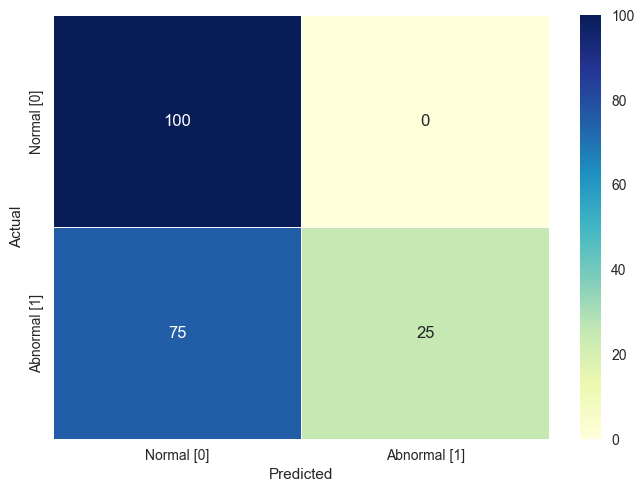

In [64]:
# IForest
confusionMatrix(predictions_ads[0]['Anomaly'])

accuracy:  0.605
recall:  0.22
precision:  0.957
f1-score:  0.358


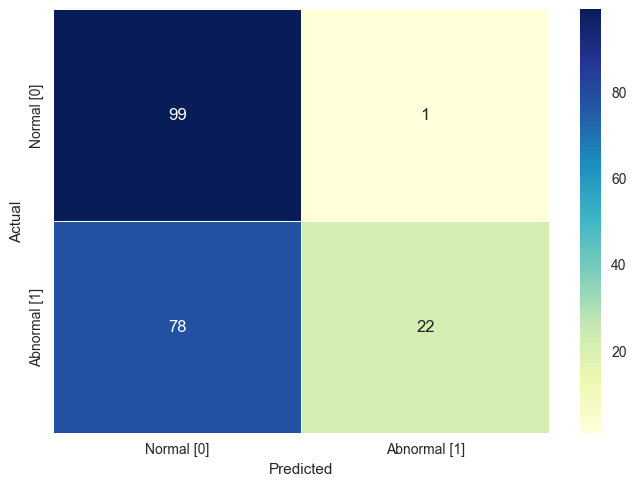

In [65]:
# KNN
confusionMatrix(predictions_ads[1]['Anomaly'])

accuracy:  0.625
recall:  0.25
precision:  1.0
f1-score:  0.4


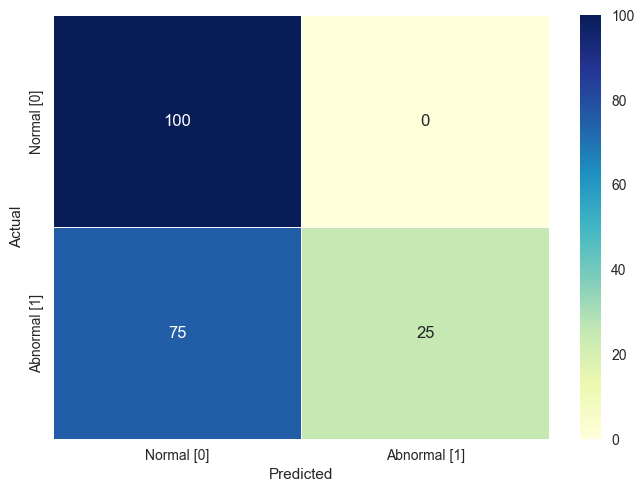

In [66]:
# SVM
confusionMatrix(predictions_ads[2]['Anomaly'])

accuracy:  0.615
recall:  0.23
precision:  1.0
f1-score:  0.374


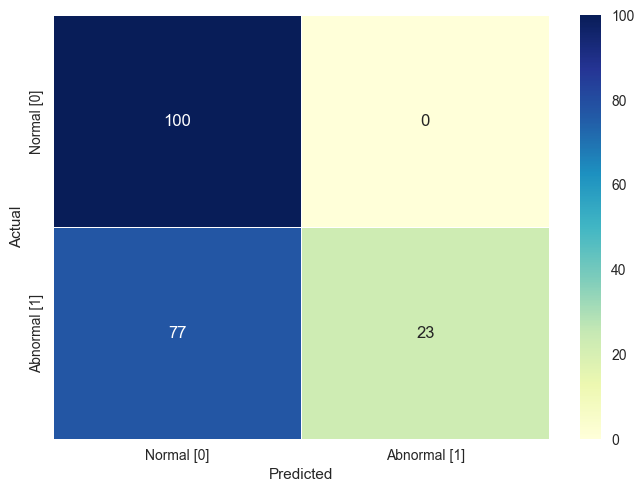

In [67]:
# PCA
confusionMatrix(predictions_ads[3]['Anomaly'])

accuracy:  0.6
recall:  0.29
precision:  0.763
f1-score:  0.42


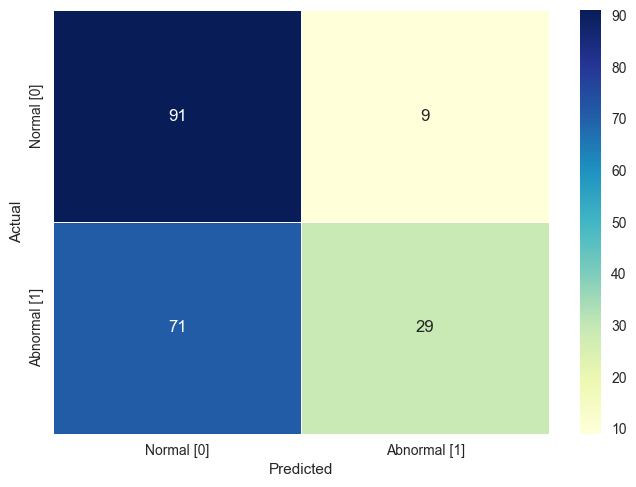

In [68]:
# LOF
confusionMatrix(predictions_ads[4]['Anomaly'])

# 6. Plotting

모델 학습 과정과 모델 해석력(SHAP), 결과에 대한 시각화를 확인할 수 있습니다.

In [ ]:
plot_model(best_model, plot='residuals')

In [ ]:
evaluate_model(best_model)

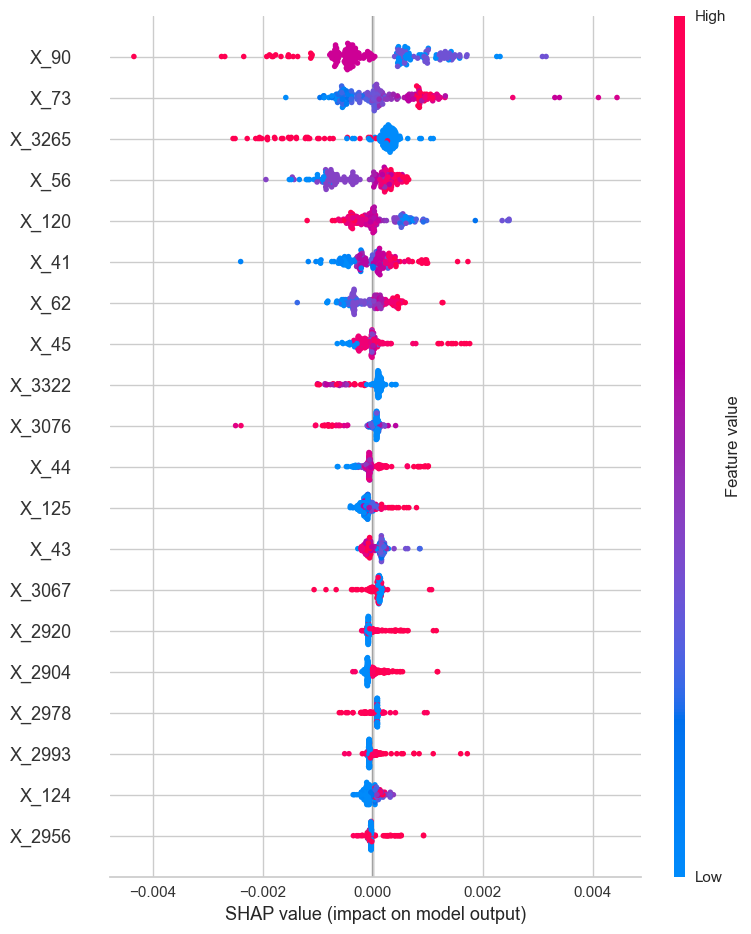

In [73]:
interpret_model(total_models[0], plot='summary')

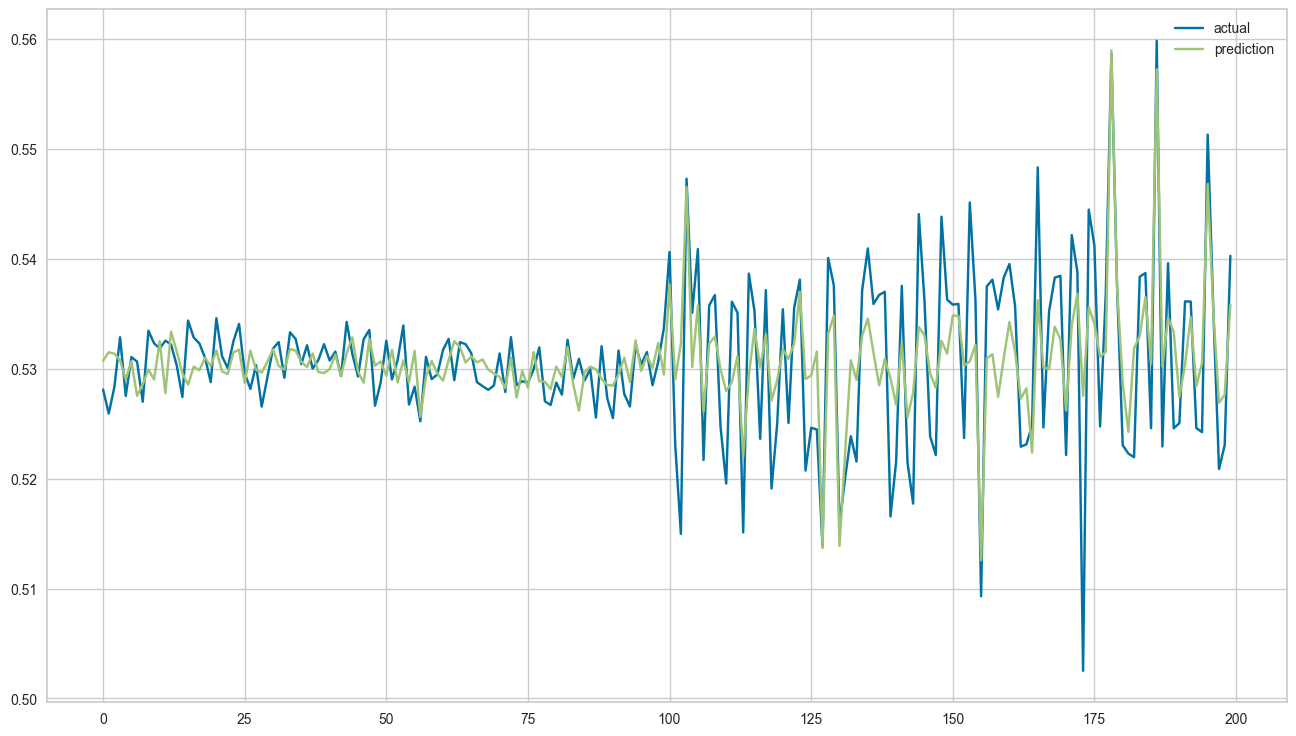

In [75]:
def graph(pred, true) :
    plt.figure(figsize=(16, 9))
    plt.plot(true, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

true_y = total_predictions[0]['Y_Quality'].to_numpy()
pred_y = total_predictions[0]['prediction_label'].to_numpy()
graph(pred_y, true_y)